# Axial Braiding

Plan: 
- write Airy function, and plot
- write Bessel function, and plot
- Superpose and plot. Explore in z
- Vary parameters
- Try combination of bessel functions, and observe solenoidal modes
- Modify l, theta, r0, s, etc.

In [254]:
import numpy as np
from matplotlib import pyplot as  plt
import scipy as sc
from scipy import special as sp

#define global parameters for Airy function
C = 1
r_0 = 5*10**-4 #0.5 mm
a = 0.2
s = 1.2*10**-4 #0.12 mm
#other parameters
wavelength = 1.064*10**-6 #1064 nm
k_0 = 2*np.pi/wavelength

def airy(x,y,z):
    #obtain intensity of Airy field at any position
    r = np.sqrt(x**2 + y**2)
    x = (r_0 - r)/s
    xi = z/(k_0 * s**2)
    g = sp.airy(x - (xi**2)/4)[0] * np.exp(a*x - a*(xi**2)/2) * np.exp(1j*(x*xi/2 + a**2*xi/2 - xi**3/12))
    #print focusing length found:
    z_f = 2*k_0*(s**2)*np.sqrt(r_0/s + 1.018 - (a**2)) #0.385m
    u_CAB = C * g * np.exp(1j*k_0*z)
    return np.real(u_CAB)**2 + np.imag(u_CAB)**2
    
def Airy_transverse_map(z):
    #plot landscape of Airy intensity at any z
    xmax = 1*10**-3
    dx = 1*10**-5
    xlist, ylist = np.arange(-xmax, xmax, dx), np.arange(-xmax, xmax, dx)
    size = int(2*xmax/dx)
    I_CAB_z_array = np.zeros((size, size))
    z_f = 2*k_0*(s**2)*np.sqrt(r_0/s + 1.018 - (a**2))
    for row in range(len(I_CAB_z_array)):
        for col in range(len(I_CAB_z_array)):
            x, y = xlist[row], ylist[col]
            intensity = airy(x,y,z)  
            I_CAB_z_array[row][col] = intensity
    plt.figure()
    plt.xlabel('x (10 microns)') #1 px = 10 microns
    plt.ylabel('y (10 microns)')
    plt.imshow(I_CAB_z_array, cmap = 'gray', interpolation = 'nearest')
    plt.colorbar()
    return

def bessel(x,y,z):
    #the parameters A, theta, l are set by the experimenters:
    A, theta, l = 1, 0.005, 0 #5, 8 mrad were used for theta
    #obtain intensity of bessel field at any point
    r = np.sqrt(x**2 + y**2)
    if x == 0:
        phi = (np.pi)/2
    else:
        phi = np.arctan(y/x)
    u_B = A * sp.jv(l,k_0*np.sin(theta)*r) * np.exp(1j*(l*phi + k_0*np.cos(theta)*z)) #Bessel function always goes to 0 as arg goes to 0
    return np.real(u_B)**2 + np.imag(u_B)**2 #no z-dependence??? #which would explain why braid starting pos only depends on Airy parameters

def Bessel_transverse_map(z):
    #plot landscape of Bessel intensity at any z
    xmax = 1*10**-3
    dx = 1*10**-5
    xlist, ylist = np.arange(-xmax, xmax, dx), np.arange(-xmax, xmax, dx)
    size = int(2*xmax/dx)
    I_Bessel_z_array = np.zeros((size, size))
    z_f = 2*k_0*(s**2)*np.sqrt(r_0/s + 1.018 - (a**2))
    for row in range(len(I_Bessel_z_array)):
        for col in range(len(I_Bessel_z_array)):
            x, y = xlist[row], ylist[col]
            intensity = bessel(x,y,z)  
            I_Bessel_z_array[row][col] = intensity
    plt.figure()
    plt.xlabel('x (10 microns)') #1 px = 10 microns
    plt.ylabel('y (10 microns)')
    plt.imshow(I_Bessel_z_array, cmap = 'gray', interpolation = 'nearest')
    plt.colorbar()
    return
    
def z_dependence(x,y):
    #plot dependence of Airy and Bessel intensity  on z
    zlist = np.arange(0, 1.0, 1*10**-4) #in m
    plt.figure()
    Airy_intensity_list = [airy(x,y,z) for z in zlist]
    Bessel_intensity_list = [bessel(x,y,z) for z in zlist]
    Superposition_intensity_list = [airy(x,y,z)+bessel(x,y,z) for z in zlist]
    plt.plot(zlist, Airy_intensity_list, 'r-')
    plt.plot(zlist, Bessel_intensity_list, 'b-')
    plt.plot(zlist, Superposition_intensity_list, 'k-')
    plt.xlabel('z (m)')
    plt.ylabel ('Intensity')
    plt.legend(['Airy', 'Bessel', 'A+B'])
    plt.show()

def x_z_braiding(y):
    xmax, zmax = 1*10**-3, 1.0
    dx, dz = 1*10**-5, 1*10**-3
    xlist = np.arange(-xmax, xmax, dx)
    zlist = np.arange(0, zmax, dz)
    intensity_array = np.zeros((len(zlist), len(xlist)))
    for zindex in range(len(zlist)): #rows are y-axis -> z
        for xindex in range(len(xlist)): #cols are x-axis
            x = xlist[xindex]
            z = zlist[zindex]
            I = bessel(x,y,z) + airy(x,y,z)
            intensity_array[zindex][xindex] = I
    plt.figure(figsize=(12,6))
    plt.xlabel('x')
    plt.ylabel('z')
    plt.imshow(intensity_array, cmap = 'gist_rainbow', interpolation = 'nearest')
    plt.colorbar()
    return

    
    

# Notes:
#### Airy beam propagates as expected. Bessel beam has zero at center, maximum at center for l=0. 

#### Airy Function

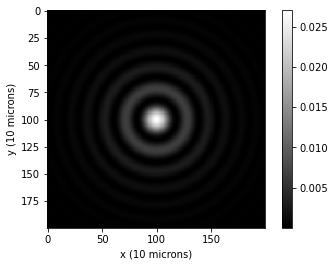

In [199]:
Airy_transverse_map(0.38)

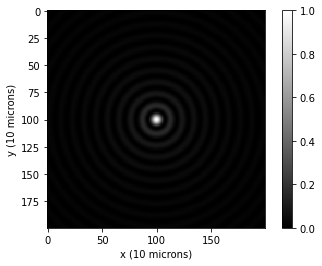

In [205]:
Bessel_transverse_map(0.38)

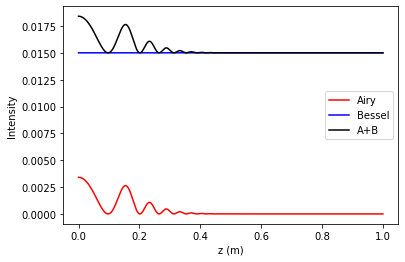

In [209]:
z_dependence(10**-3, 10**-3)

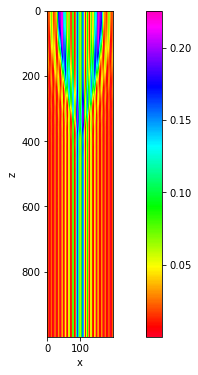

In [260]:
x_z_braiding(0.1*10**-3)